# The Novel Enhanced Quantum Representation (NEQR) 

The Novel Enhanced Quantum Representation (NEQR)is an earlier form of quantum image representation. It uses a normalized superposition to store pixels in an image. NEQR was created to improve over Flexible Representation of Quantum Images (FRQI) by leveraging the basis state of a qubit sequence to store the image's grayscale value. NEQR offers the following advantages over FRQI as demonstrated in [1]:




1. Quadratic speedup of the time complexity to prepare the NEQR quantum image
2. Optimal image compression ratio of up to 1.5×
3. Accurate image retrieval after measurement, as opposed to probabilistic as FRQI
4. Complex color and many other operations can be achieved

In [ ]:
! pip install qiskit

In [2]:
import numpy as np
from PIL import Image

#Open a list of 100 images and translate each pixel into a 8 bits data
data = [] #100 images, 64 pixels, 8 bits
for i in range(100):
  foto = Image.open('Grey-{}.png'.format(i))
  image1 = np.array(list(foto.getdata()))
  foto.close()
  for j in range(len(image1)):
    data.append(np.binary_repr(image1[j], width=8))

The NEQR process to represent an image is composed of two parts; preparation and compression and are described as follows. We will first create one quantum circuit for the pixel values, and the other for the pixel positions. 

In [3]:
import qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import *

IBMQ.save_account(#IBMaccount)
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2020-07-23 12:44:09,626: Credentials already present. Set overwrite=True to overwrite.


To define the first circuit, we need to define the range of the grayscale intensity for each pixel, since the most common grayscale range is generally from 0-256, 8 qubits will be needed since 256 = 2^q. 

In our case we wanted to encode images of galaxies but due to the computational cost we reduced them to 8x8 grayscale images and consider this case as a toy model. That is the reason why our second quantum circuit will include the 6 qubits to represent the pixel positions since we will represent an 8x8 image with 64 positions and 2^6 = 64. So the final circuit will have 8+6=14 qubits to represent an 8x8 grayscale image.

In [4]:
final_output = []

#for over the 100 images

for j in range(100):
  num_qubits = 8 + 6 #8 qubits for pixels and 6 qubits for data
  qc_image = QuantumCircuit(num_qubits)

  # Create the pixel position qubits, and place them in superposition.
  qc_pos = QuantumCircuit(6)
  qc_pos.h(0)
  qc_pos.h(1)
  qc_pos.h(2)
  qc_pos.h(3)
  qc_pos.h(4)
  qc_pos.h(5) 
  
  # Setup color value qubits
  qc_grayscale = QuantumCircuit(8)
  for idx in range(8):
      qc_grayscale.i(idx)
  
  # Compose the circuit by appending the pixel and grayscale qubits
  qc_image.compose(qc_pos, qubits=[num_qubits-1,num_qubits-2,num_qubits-3,num_qubits-4,num_qubits-5,num_qubits-6], inplace=True)
  qc_image.compose(qc_grayscale, qubits=[0, 1, 2, 3, 4, 5, 6, 7], inplace=True)
  qc_image.barrier()

  # Add the CNOT gates
  for i in range(64):
    qc_image.x(num_qubits-1)
    for idx, px_value in enumerate(data[j * 64 + i]):
        if(px_value=='1'):
            
            qc_image.ccx(num_qubits-1,num_qubits-2, idx)
    qc_image.x(num_qubits-1)
    qc_image.barrier()

  #run circuit in backend and get the state vector
  backend = Aer.get_backend('statevector_simulator')
  result = qiskit.execute(qc_image, backend=backend).result()
  output = result.get_statevector(qc_image)
  final_output.append(output)

In [8]:
#draw the last circuit
qc_image.draw()

┌───┐ ░                      ░                           ░           »
 q_0: ┤ I ├─░──────────────────────░───────────────────────────░───────────»
      ├───┤ ░                      ░                           ░           »
 q_1: ┤ I ├─░──────────────────────░───────────────────────────░───────────»
      ├───┤ ░                      ░                           ░           »
 q_2: ┤ I ├─░──────────────────────░───────────────────────────░───────────»
      ├───┤ ░      ┌───┐           ░      ┌───┐                ░      ┌───┐»
 q_3: ┤ I ├─░──────┤ X ├───────────░──────┤ X ├────────────────░──────┤ X ├»
      ├───┤ ░      └─┬─┘           ░      └─┬─┘                ░      └─┬─┘»
 q_4: ┤ I ├─░────────┼─────────────░────────┼──────────────────░────────┼──»
      ├───┤ ░        │             ░        │  ┌───┐           ░        │  »
 q_5: ┤ I ├─░────────┼─────────────░────────┼──┤ X ├───────────░────────┼──»
      ├───┤ ░        │             ░        │  └─┬─┘┌───┐      ░        │  »
 q_6: ┤ I ├─░────────┼─────────────░────────┼────┼──┤ X ├──────░────────┼──»
      ├───┤ ░        │  ┌───┐      ░        │    │  └─┬─┘      ░        │  »
 q_7: ┤ I ├─░────────┼──┤ X ├──────░────────┼────┼────┼────────░────────┼──»
      ├───┤ ░        │  └─┬─┘      ░        │    │    │        ░        │  »
 q_8: ┤ H ├─░────────┼────┼────────░────────┼────┼────┼────────░────────┼──»
      ├───┤ ░        │    │        ░        │    │    │        ░        │  »
 q_9: ┤ H ├─░────────┼────┼────────░────────┼────┼────┼────────░────────┼──»
      ├───┤ ░        │    │        ░        │    │    │        ░        │  »
q_10: ┤ H ├─░────────┼────┼────────░────────┼────┼────┼────────░────────┼──»
      ├───┤ ░        │    │        ░        │    │    │        ░        │  »
q_11: ┤ H ├─░────────┼────┼────────░────────┼────┼────┼────────░────────┼──»
      ├───┤ ░        │    │        ░        │    │    │        ░        │  »
q_12: ┤ H ├─░────────■────■────────░────────■────■────■────────░────────■──»
      ├───┤ ░ ┌───┐  │    │  ┌───┐ ░ ┌───┐  │    │    │  ┌───┐ ░ ┌───┐  │  »
q_13: ┤ H ├─░─┤ X ├──■────■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░─┤ X ├──■──»
      └───┘ ░ └───┘          └───┘ ░ └───┘               └───┘ ░ └───┘     »
«                      ░                           ░                          »
« q_0: ────────────────░───────────────────────────░──────────────────────────»
«                      ░                           ░                          »
« q_1: ────────────────░───────────────────────────░──────────────────────────»
«                      ░                           ░                          »
« q_2: ────────────────░───────────────────────────░──────────────────────────»
«                      ░      ┌───┐                ░      ┌───┐               »
« q_3: ────────────────░──────┤ X ├────────────────░──────┤ X ├───────────────»
«                      ░      └─┬─┘                ░      └─┬─┘               »
« q_4: ────────────────░────────┼──────────────────░────────┼─────────────────»
«      ┌───┐           ░        │  ┌───┐           ░        │  ┌───┐          »
« q_5: ┤ X ├───────────░────────┼──┤ X ├───────────░────────┼──┤ X ├──────────»
«      └─┬─┘┌───┐      ░        │  └─┬─┘┌───┐      ░        │  └─┬─┘┌───┐     »
« q_6: ──┼──┤ X ├──────░────────┼────┼──┤ X ├──────░────────┼────┼──┤ X ├─────»
«        │  └─┬─┘      ░        │    │  └─┬─┘      ░        │    │  └─┬─┘     »
« q_7: ──┼────┼────────░────────┼────┼────┼────────░────────┼────┼────┼───────»
«        │    │        ░        │    │    │        ░        │    │    │       »
« q_8: ──┼────┼────────░────────┼────┼────┼────────░────────┼────┼────┼───────»
«        │    │        ░        │    │    │        ░        │    │    │       »
« q_9: ──┼────┼────────░────────┼────┼────┼────────░────────┼────┼────┼───────»
«        │    │        ░        │    │    │        ░        │    │    │       »
«q_10: ──┼────┼────────░────────┼────┼────┼────────░────────┼────┼────┼───────»
«        │   

In [5]:
#print the amount of circuits necesary
print('Circuit depth: ', qc_image.decompose().depth())
print('Circuit size: ', qc_image.decompose().size())
print('Gate decomposition:', qc_image.decompose().count_ops())

Circuit depth:  2319
Circuit size:  3427
Gate decomposition: OrderedDict([('cx', 1314), ('t', 876), ('tdg', 657), ('h', 438), ('u3', 128), ('barrier', 65), ('id', 8), ('u2', 6)])


Original shape: (100, 16384) . New shape: (100, 31) . Score: 38968.651074004614
Original shape: (100, 16384) . New shape: (100, 37) . Score: 39671.13851404483
Original shape: (100, 16384) . New shape: (100, 43) . Score: 40611.65873195469
Original shape: (100, 16384) . New shape: (100, 49) . Score: 41944.46489666756
Original shape: (100, 16384) . New shape: (100, 55) . Score: 44021.2158709857
Original shape: (100, 16384) . New shape: (100, 61) . Score: 47903.56146275331
Original shape: (100, 16384) . New shape: (100, 67) . Score: 62411.205709618196


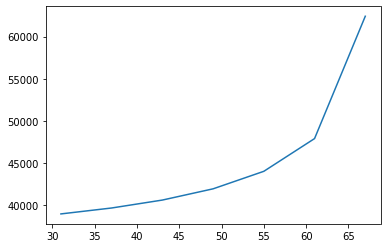

In [13]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#compressing data to see the minimun amount of components needed without losing information
score = []
for i in np.arange(31,68,6):
  final_output0 = np.array(final_output).real
  pca = PCA(n_components=i)
  pca.fit(final_output0)
  final_output1 = np.array(pca.transform(final_output0))

  score_temp = pca.score(final_output0)
  score.append(score_temp)
  print("Original shape:",final_output0.shape,". New shape:",final_output1.shape,". Score:", score_temp)

plt.plot(np.arange(31,68,6), score)

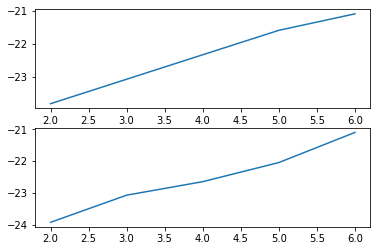

In [7]:
score0 = []
score1 = []

# we aplied kmeans in the original state vector and
# in the compressed version and see no differents in
# the results

for i in range(5):
  kmeans0 = KMeans(n_clusters=i+2).fit(final_output0)
  score0.append(kmeans0.score(final_output0))
  kmeans1 = KMeans(n_clusters=i+2).fit(final_output1)
  score1.append(kmeans1.score(final_output1))

plt.subplot(2,1,1)
plt.plot(np.arange(2,7),score0)
plt.subplot(2,1,2)
plt.plot(np.arange(2,7),score1)